Chart hospitalizations from COVID-19 in Ottawa.

Richard Akerman

December 31, 2021

Code developed in Google Colaboratory will be posted to GitHub (scilib) with MIT License.

Code uses examples and techniques from:

*   Data to Fish - [How to Select Rows from Pandas DataFrame](https://datatofish.com/select-rows-pandas-dataframe/)
*   [matplotlib.pyplot.bar](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html)
*   Stack Overflow - Python - [Get list from pandas dataframe column or row?](https://stackoverflow.com/questions/22341271/get-list-from-pandas-dataframe-column-or-row)
*   tutorialspoint - [Matplotlib - Bar Plot](https://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.htm)
*   Geeks for Geeks - [Plotting multiple bar charts using Matplotlib in Python](https://www.geeksforgeeks.org/plotting-multiple-bar-charts-using-matplotlib-in-python/)
*Geeks for Geeks - [Matplotlib.pyplot.colors() in Python](https://www.geeksforgeeks.org/matplotlib-pyplot-colors-in-python/)
*   Google - [Charting in Colaboratory](https://colab.research.google.com/notebooks/charts.ipynb)

Data from Ontario open data - [lCOVID-19 cases in hospital and ICU, by Ontario Health (OH) region](https://data.ontario.ca/en/dataset/covid-19-cases-in-hospital-and-icu-by-ontario-health-region)

This is rows labeled by region, EAST is the one this code uses.

Verified that East is the correct region for Ottawa, see e.g. [Ontario Public Health Units and Health Unit Regions](https://www.researchgate.net/figure/Ontario-public-health-units-and-health-unit-regions_fig1_322667994)

Note that what is plotted for ICU is cases that are currently testing positive for COVID-19, not total cases, due to some historical issues with the dataset.

TODO: Label chart with dates

Caveats: Will break if data URL changes or if data format changes.

            date  hospitalizations  icu_current_covid  icu_current_covid_vented
1262  2021-12-18                82                 27                        20
1263  2021-12-19                67                 29                        23
1264  2021-12-20                67                 29                        23
1265  2021-12-21                77                 30                        23
1266  2021-12-22                74                 31                        23
1267  2021-12-23                83                 32                        20
1268  2021-12-24                88                 29                        18
1269  2021-12-25                82                 27                        14
1270  2021-12-26                94                 26                        14
1271  2021-12-27               107                 27                        16
1272  2021-12-28               144                 31                        15
1273  2021-12-29               154      

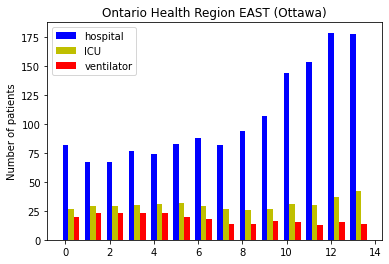

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

hospitalizations_url = "https://data.ontario.ca/dataset/8f3a449b-bde5-4631-ada6-8bd94dbc7d15/resource/e760480e-1f95-4634-a923-98161cfb02fa/download/region_hospital_icu_covid_data.csv"
hospitalizations_data = pd.read_csv(hospitalizations_url)

# extract most recent number_of_items days of hospitalizations
# Ottawa is Ontario Health region EAST

desired_row = "EAST"
hospital_column = "hospitalizations"
hospital_label = 'hospital'
icu_column = "icu_current_covid"
icu_label = 'ICU'
ventilator_column = 'icu_current_covid_vented'
ventilator_label = 'ventilator'
number_of_items = 14
offset_width = 0.25

# extract only the rows matching desired_row (EAST)
selected_hospital_rows = hospitalizations_data.loc[hospitalizations_data['oh_region'] == desired_row]

# make a table
print(selected_hospital_rows[['date', hospital_column, icu_column, ventilator_column]].tail(number_of_items))
print("\n")

# make a chart
r = np.arange(number_of_items) # just a set of index values for the plot

plt.bar( r , list(selected_hospital_rows[hospital_column].tail(number_of_items)), color ='b' , label = hospital_label, width = offset_width)
plt.bar( r + offset_width, list(selected_hospital_rows[icu_column].tail(number_of_items)), color ='y', label = icu_label, width = offset_width)
plt.bar( r + offset_width + offset_width, list(selected_hospital_rows[ventilator_column].tail(number_of_items)), color ='r', label = ventilator_label, width = offset_width)

plt.plot()

plt.ylabel("Number of patients")
plt.title("Ontario Health Region EAST (Ottawa)")
plt.legend()
plt.show()